# Recurrent Neural Network
 
Welcome to the fifth laboratory class of HDA course!

**Today you will see:**
- an example of a more advanced data loading process using the TensorFlow Data API
- an implementation of a recurrent network

**After this assignment you will be able to:**

- load the data using the TensorFlow input pipeline
- build and train an RNN-CNN network in TensorFlow for a classification problem 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import os
import zipfile
from scipy.signal import medfilt
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

2022-12-11 18:16:16.856451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ## 1 - Data loading and preprocessing
 The dataset aims to encourage the development of algorithms to classify, from a single short ECG lead recording (between 30 s and 60 s in length), whether the recording shows normal sinus rhythm, atrial fibrillation (Afib), an alternative rhythm, or is too noisy to be classified.

 To make the problem a little bit easier, in this class we will just consider normal sinus rhythm and Afib traces, trying to train a classifier that is able to discriminate between these two cases.

 More information about the dataset can be found here: [https://physionet.org/challenge/2017](https://physionet.org/challenge/2017)

 ### 1.2 - Create data folder
 First, if not done yet, let's decompress the zip data file.

In [2]:
# Define the data folder location
data_dir = 'data'

# Extract data from zip file
if not os.path.exists(data_dir):
    with zipfile.ZipFile('data.zip', 'r') as f:
        f.extractall('.')

### 1.3 - Import labels

Each signal is stored in a separate file in the "./data" folder, while the labels are listed in the "./data/REFERENCE-v3.csv" file.

The label file includes two columns: the first represents the filename where the data is stored, the second represents the actual label, manually determined by human experts. The labels are:
 - **N** -> Normal sinus rhythm
 - **A** -> Atrial Fibrillation
 - **O** -> Other abnormal rhythms
 - **~** -> Noisy traces


The following code performs these operations:
- Load the reference file as a Pandas DataFrame object ([documentation here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)). Use the ``read_csv`` function of the Pandas library (here imported as `pd`) ([documentation here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas.read_csv)) using as parameters: ```index_col=0``` to use column 0 as row labels, ```header=None``` and ```names=['label']``` to use 'label' as the name of the column
 
- Select only the files with labels **N** or **A** using masking. To create the mask: use ```(reference_df['label'] == 'xxx')``` to set one condition for the selection and combine the two conditions using the **or** operator ```condition1 | condition2```. Apply the mask using: 
```python
reference_df[mask]
```


- Replace **N** with 0 (negative class) and **A** with 1 (positive class). Use the ``apply`` function of Pandas ([documentation here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)) that is used to apply a function to a DataFrame. Our function is ```lambda l: 0 if l == 'N' else 1```: see [here](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) the documentation for the "lambda" keyword. Putting all together, the final expression to use is: 
```python
reference_df['label'] = reference_df['label'].apply(lambda l: 0 if l == 'N' else 1)
```

In [3]:
# Create a dataframe containing all the files and the labels from the reference file
# START CODE HERE ### (1 line)
reference_df = pd.read_csv('data/REFERENCE-v3.csv', index_col=0, header=None, names=['label'])
### END CODE HERE ###

# Just consider the 'N' and the 'A' class
# START CODE HERE ### (2 lines)
mask = (reference_df['label'] == 'N') | (reference_df['label'] == 'A')
reference_df = reference_df[mask]
### END CODE HERE ###

# Replace 'N' with 0 and 'A' with 1
# START CODE HERE ### (1 line)
reference_df['label'] = reference_df['label'].apply(lambda l: 0 if l == 'N' else 1)
### END CODE HERE ###

# Print the result
print(reference_df)

        label
A00001      0
A00002      0
A00003      0
A00004      1
A00005      1
...       ...
A08523      1
A08524      0
A08526      0
A08527      0
A08528      0

[5834 rows x 1 columns]


### 1.4 - Create a validation set
As you can see from the previous output, we have now proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

However, before loading the data, let's keep a subset of data out for validation (20% of the data).

To this end, use the `train_test_split` function from the scikit-learn library as done in Lab 3 ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). Specifically, for the function parameters:

- use the proper ```test_size``` parameter to retain 20% of data for validation 
- set ```stratify=reference_df['label']``` to keep the percentage of elements for each class equally distributed among the train and the validation set
- ```random_state=123``` for reproducible outputs

**Hint**: Take also a look at different splitting strategies provided by scikit-learn [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection). These are extremely useful for many machine learning tasks, especially for cross-validation.

**NOTE**: If your hardware is not powerful enough, or if you want to perform some tests without loading the entire dataset, just set *smoke_test=True*. This will reduce the train and validation set to only *smoke_test_size* elements. Of course, the results won't be reliable, but this may be useful to test if everything is working as intended before the full training.

In [4]:
# Enable smoke test
smoke_test = False
smoke_test_size = 50

# Keep 20% of the data out for validation
### START CODE HERE ### (1 line)
train_reference_df, val_reference_df = train_test_split(reference_df, test_size=0.2, stratify=reference_df['label'], random_state=123)
### END CODE HERE ###

if smoke_test:
    train_reference_df = train_reference_df[:smoke_test_size]
    val_reference_df = val_reference_df[:smoke_test_size]

# Count the elements in the sets
num_train_data_normal = sum(train_reference_df['label'] == 0)
num_train_data_afib   = sum(train_reference_df['label'] == 1)
num_val_data_normal   = sum(val_reference_df['label'] == 0)
num_val_data_afib     = sum(val_reference_df['label'] == 1)

print('TRAIN SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_train_data_normal, 100 * num_train_data_normal / len(train_reference_df)))
print('\tAfib ECG: {} ({:.2f}%)'.format(num_train_data_afib, 100 * num_train_data_afib / len(train_reference_df)))
print('VALIDATION SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_val_data_normal, 100 * num_val_data_normal / len(val_reference_df)))
print('\tAfib ECG: {} ({:.2f}%)'.format(num_val_data_afib, 100 * num_val_data_afib / len(val_reference_df)))

TRAIN SET
	Normal ECG: 4061 (87.02%)
	Afib ECG: 606 (12.98%)
VALIDATION SET
	Normal ECG: 1015 (86.98%)
	Afib ECG: 152 (13.02%)


**Expected Output**

<table> 
<tr>
<td>
    TRAIN SET
    
	Normal ECG: 4061 (87.02%)
	Afib ECG: 606 (12.98%)
</td>
</tr>
<tr>
<td>
    VALIDATION SET
    
	Normal ECG: 1015 (86.98%)
	Afib ECG: 152 (13.02%)
</td>
</tr>
</table>

### 1.5 - Load data
Now we define a function to load the actual signals from the files. Data is stored as *.mat* files (MATLAB format). Python can easily load this data using the `loadmat` function from the SciPy library ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html)). 

The function takes the complete path of the file to be loaded as input: it can be composed using the filename *file_name* and the data main directory *data_dir* (in our case *data*, defined at the beginning of the notebook). The complete path of the file will be: 
```python
file_mat = data_dir + '/' + file_name + '.mat'
```
After loading it, you have to extract the specific field from the matlab file: use ```['val']``` after the execution of "loadmat(...)"

An example of a normal sinus rhythm and an Afib is shown. As you can see, during atrial fibrillation the ECG exhibits a more irregular beating.

 **NOTE**: The method *.decode()* is required because TensorFlow encodes string data as bytes object when it uses a custom Python function, as you will use below. The *.decode()* method simply converts a sequence of bytes to a string (by default, UTF-8 will be used as standard character encoding).

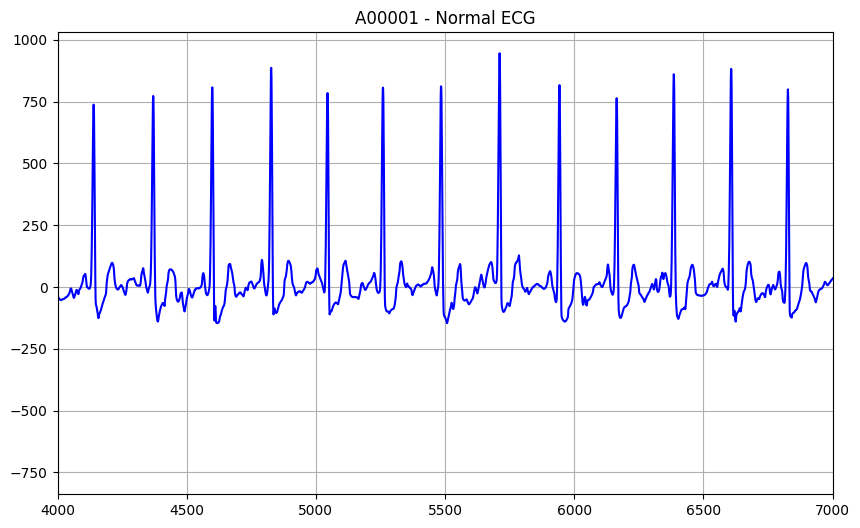

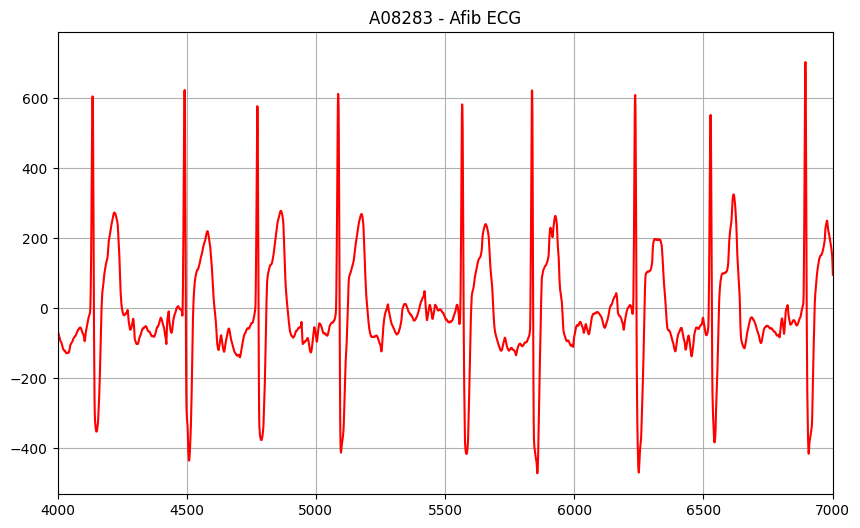

In [5]:
def load_data(file_name, data_dir):
    if isinstance(data_dir, bytes):
        data_dir = data_dir.decode()
    if isinstance(file_name, bytes):
        file_name = file_name.decode()
    # Load the ECG signal from the .mat file
    ### START CODE HERE ### (2 lines)
    file_mat = data_dir + '/' + file_name + '.mat'
    data = loadmat(file_mat)['val']
    ### END CODE HERE ###
    return data.squeeze()

# Examples

# Plot a Normal ECG
file_name = 'A00001'

# Call the function you defined above with the proper arguments (hint: we defined above the folder name as 'data_dir')
### START CODE HERE ### (1 line)  
normal_data = load_data(file_name, data_dir)
### END CODE HERE ###

plt.figure()
plt.plot(normal_data, color='b')
plt.xlim([4000, 7000])
plt.title('{} - Normal ECG'.format(file_name))

# Plot an Afib ECG
file_name = 'A08283'

# Call the function you defined above with the proper arguments
### START CODE HERE ### (1 line) 
afib_data = load_data(file_name, data_dir)
### END CODE HERE ###

plt.figure()
plt.plot(afib_data, color='r')
plt.xlim([4000, 7000])
plt.title('{} - Afib ECG'.format(file_name))
plt.show()

### 1.6 - Preprocessing: baseline wander removal
**Baseline wander** is a low-frequency artifact in the ECG that arises from several factors, such as breathing, electrically charged electrodes, or subject movement. In the ECG signal, it can be seen as a low-frequency trend, which is not related to the heart activity and should be removed.

<img src="img/bwr.png" width="60%"/>

Even though it may seem trivial, the preservation of the shape of the actual ECG is of primary importance, since it has components also in the low-frequency band.

There are several ways to cope with this problem. Without going too much into the details, an easy way to do that is to use median filters (one with 0.2 seconds and one with 0.6 seconds window size) to estimate the baseline, and then remove it from the signal. We are going to use the `medfilt` function provided by SciPy ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html)).
You have to apply twice the filter using the different window sizes:
```python 
win_size = int(np.round(x_seconds * fs)) + 1
baseline = medfilt(filter input, win_size)
```

 As you can see, after the process the low electrical activity of the ECG is almost centered to zero.

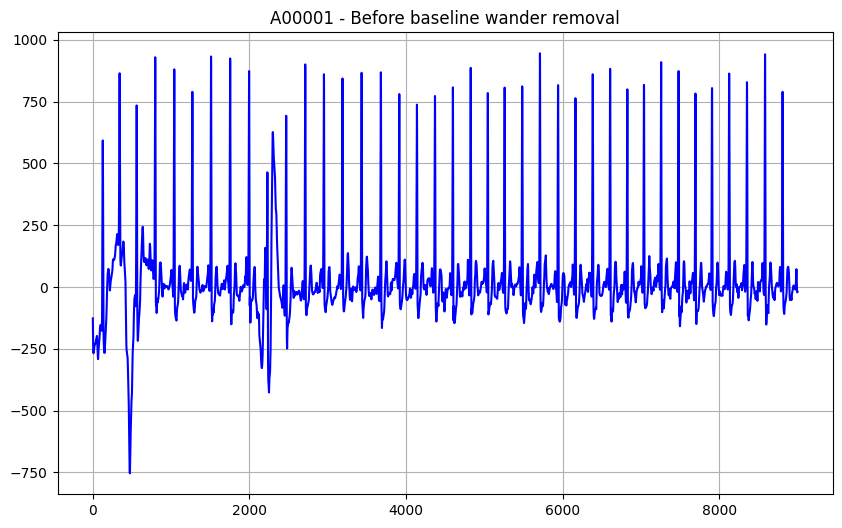

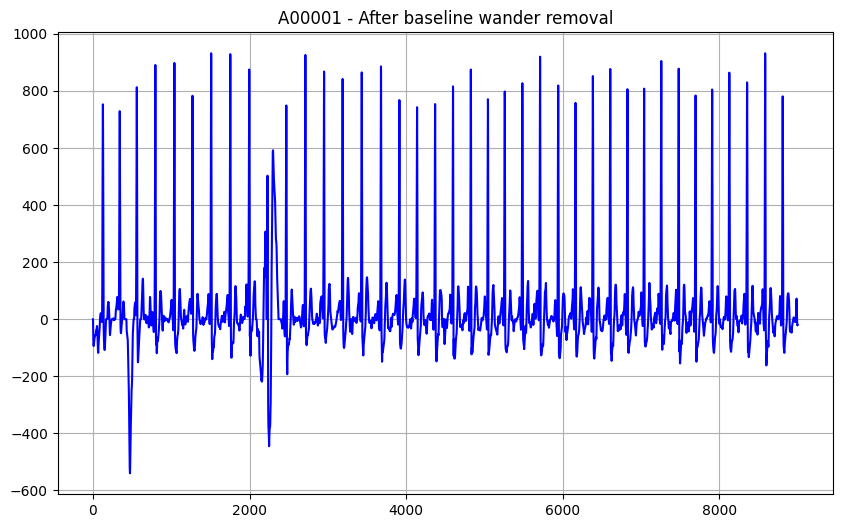

In [6]:
def baseline_wander_removal(data):
    # Sampling frequency
    fs = 300
    
    # Baseline estimation
    
    ### START CODE HERE ### (2 lines)  
    win_size = int(np.round(0.2 * fs)) + 1
    baseline = medfilt(data, win_size)
    ### END CODE HERE ###
    
    ### START CODE HERE ### (2 lines)  
    win_size = int(np.round(0.6 * fs)) + 1 
    baseline = medfilt(baseline, win_size)
    ### END CODE HERE ###
    
    # Removing baseline
    filt_data = data - baseline
    return filt_data
    
# Example
file_name = 'A00001'

# Load the data and apply the baseline wander removal using the two helper functions you implemented above
### START CODE HERE ### (2 lines)  
data = load_data(file_name, data_dir)
filt_data = baseline_wander_removal(data)
### END CODE HERE ###

plt.figure()
plt.plot(data, color='b')
plt.title('{} - Before baseline wander removal'.format(file_name))
plt.figure()
plt.plot(filt_data, color='b')
plt.title('{} - After baseline wander removal'.format(file_name))
plt.show()

### 1.7 - Preprocessing: normalization
**Normalization** is another important step. Depending on the subject, its skin resistivity, the quality of the electrical connection of the electrodes and many other factors, the amplitude of the ECG may be highly affected.

In this case, since we are more interested in the shape of the signal than in its amplitude, we perform an element-wise normalization, which means that the normalization is applied independently on each trace.

For this purpose, we simply estimate the signal amplitude using the 99th and the 5th percentile (to exclude some possible outliers, more robust compared with max/min when using real-world data) and normalize with respect to this value ([documentation here](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)).

 The result is a signal that is almost in the range \[-1, 1\].

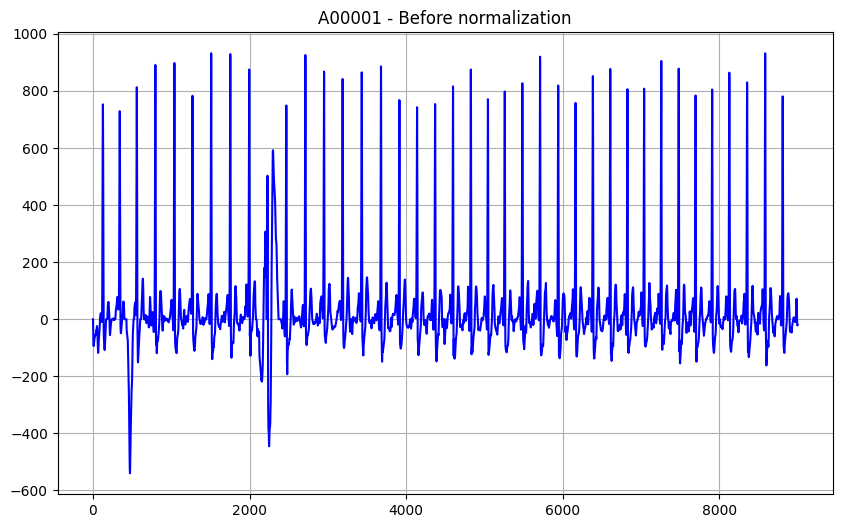

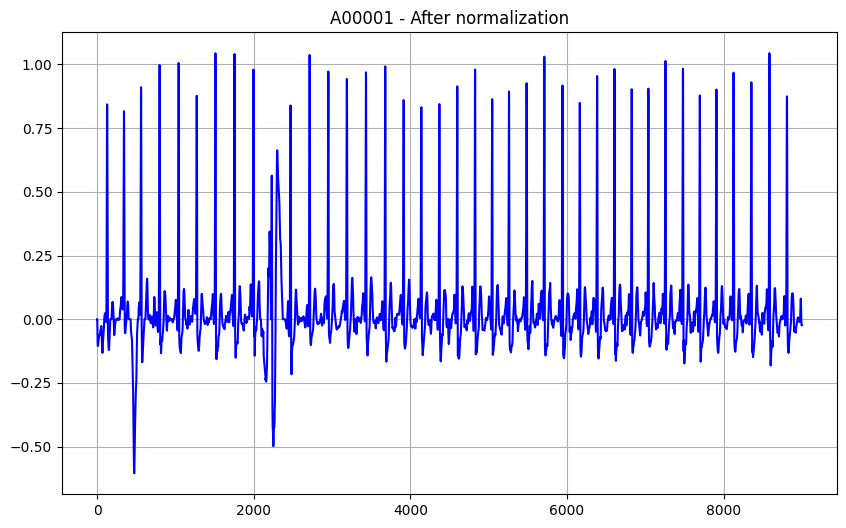

In [7]:
def normalize_data(data):
    # Amplitude estimate
    norm_factor = np.percentile(data, 99) - np.percentile(data, 5)
    return (data / norm_factor)
    
# Example
file_name = 'A00001'

# Load the data, apply the baseline wander removal and normalize the data using the three helper functions you implemented above
### START CODE HERE ### (2 lines) 
data = load_data(file_name, data_dir)
filt_data = baseline_wander_removal(data)
norm_data = normalize_data(filt_data)
### END CODE HERE ###

plt.figure()
plt.plot(filt_data, color='b')
plt.title('{} - Before normalization'.format(file_name))
plt.figure()
plt.plot(norm_data, color='b')
plt.title('{} - After normalization'.format(file_name))
plt.show()

 ### 1.8 - Preprocessing: random crop
 First, let's print the shapes of some of the training data (the first 50 elements).

In [8]:
for name in list(train_reference_df.index[:50]):
    data = load_data(name.encode(), data_dir)
    print('File: {} - Shape: {}'.format(name, data.shape))

File: A08283 - Shape: (9000,)
File: A08212 - Shape: (18000,)
File: A02509 - Shape: (9000,)
File: A01028 - Shape: (9000,)
File: A03827 - Shape: (9000,)
File: A07246 - Shape: (9000,)
File: A00258 - Shape: (5288,)
File: A01823 - Shape: (8294,)
File: A05543 - Shape: (9000,)
File: A01364 - Shape: (2796,)
File: A06746 - Shape: (4648,)
File: A00360 - Shape: (9000,)
File: A08237 - Shape: (9000,)
File: A01793 - Shape: (9000,)
File: A04979 - Shape: (9000,)
File: A06984 - Shape: (9000,)
File: A06245 - Shape: (9624,)
File: A03104 - Shape: (6264,)
File: A05082 - Shape: (18000,)
File: A00381 - Shape: (9000,)
File: A06528 - Shape: (9000,)
File: A05307 - Shape: (9000,)
File: A00940 - Shape: (18000,)
File: A00643 - Shape: (18000,)
File: A07158 - Shape: (18216,)
File: A03574 - Shape: (10450,)
File: A04776 - Shape: (9000,)
File: A00079 - Shape: (9000,)
File: A03529 - Shape: (9000,)
File: A02879 - Shape: (9000,)
File: A05669 - Shape: (9492,)
File: A01555 - Shape: (9000,)
File: A04934 - Shape: (3826,)
File

As you can see, the signals have different lengths. However, for this network implementation, we need the input shape to be fixed.

Most of the signals have **9000** samples (30 seconds, considering the **300 Hz** sampling frequency), so let's use this value as our fixed input shape.

If the signal is too short (< 9000 samples), we **pad the vector with zeros** to match the required size. Use the function ``pad`` of the NumPy library (loaded as `np`), you can find [here](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) the documentation. Pad half on the left (```int(np.ceil(tot_pads / 2))```) and half on the right (```int(np.floor(tot_pads / 2))```), ceil and floor are used to manage odd values for ``` tot_pad```. Use ```mode='constant'``` to pad with zeros (default value for the function).

If the signal is too long (> 9000 samples), we randomly select a portion of the signal (**crop**) to match the required size. This operation should be repeated every time the data is sampled during the training phase, always selecting a different portion of the signal. In this way, we exploit all the available information (**never waste your data**).

 **NOTE**: Typically, validation/test should be performed always on the same data (without any randomness). For this reason, we also include the parameter **center_crop**. if *center_crop=True*, instead of randomly selecting 9000 samples from the signal, we always take them in the middle of the signal. *center_crop* will be set to *True* for the validation dataset.

 The following plots show the signal 'A03027', which has 18000 samples, and an example of 3 random crops.

 **Hint**: Try to set *center_crop=True* in the code to be sure that the 3 crops are exactly the same.

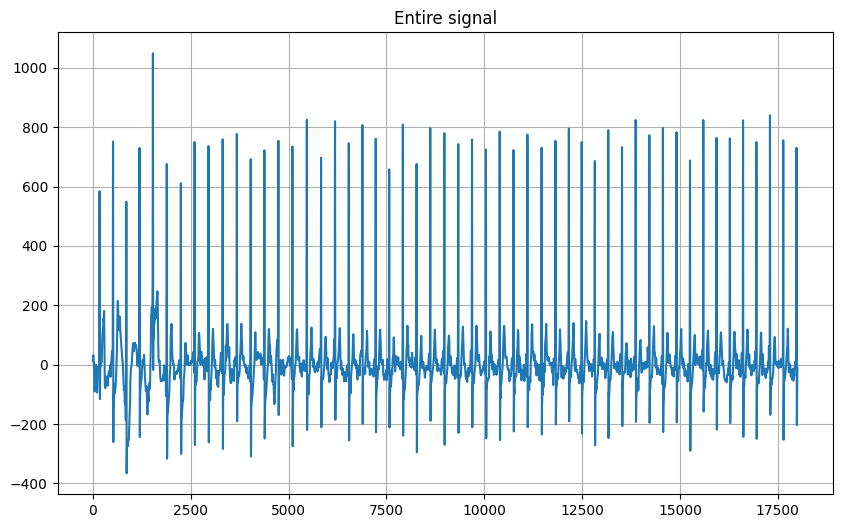

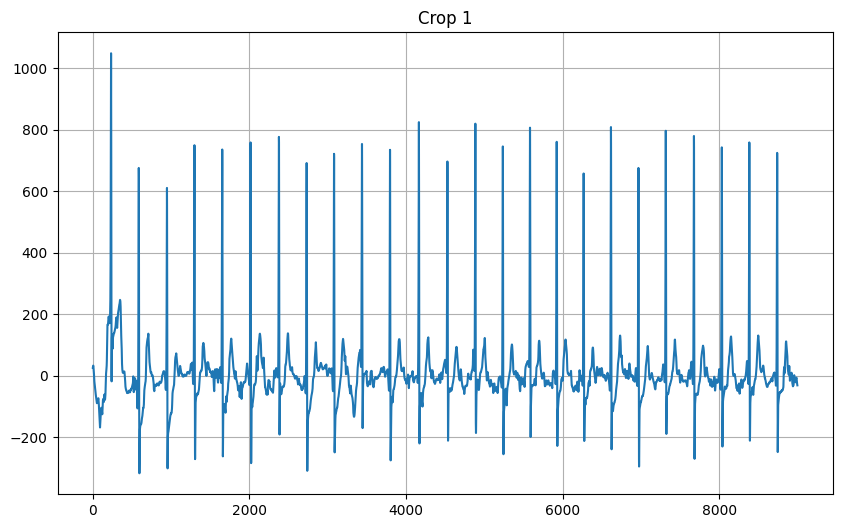

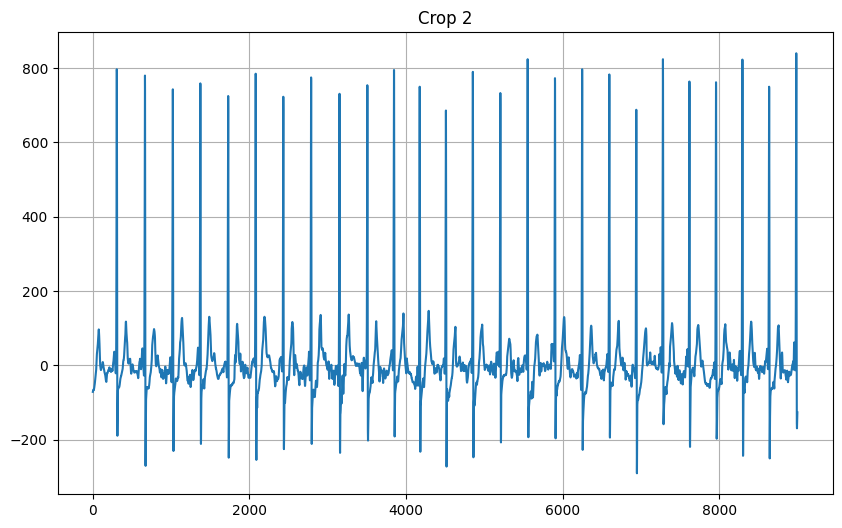

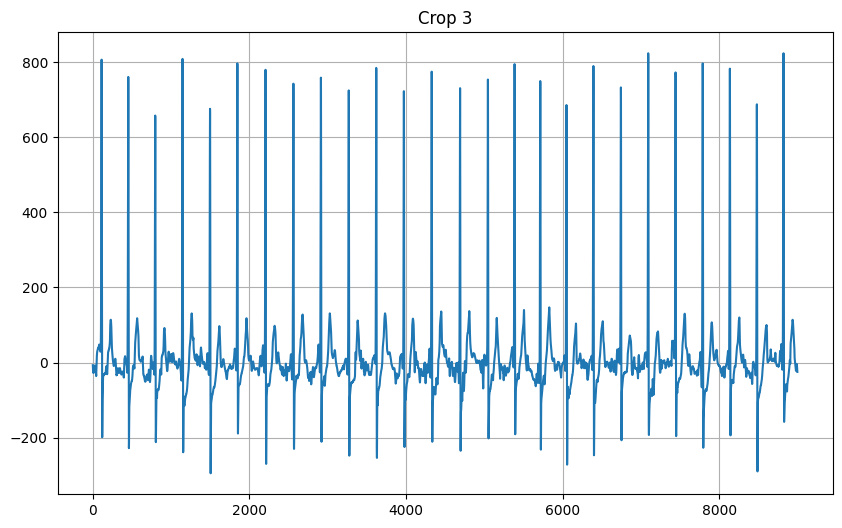

In [9]:
# NOTE: inside a function there can be different "return" statements for different conditions
# when a condition is met and the return statement is executed, all the code below will not be executed

def random_crop(data, target_size=9000, center_crop=False):
    N = data.shape[0]
    
    # Return data if correct size
    ### START CODE HERE ### (2 lines) 
    if N == target_size:
        return data
    ### END CODE HERE ###
    
    # If data is too small, then pad with zeros
    ### START CODE HERE ### (5 lines) 
    if N < target_size:
        tot_pads = target_size - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2)) # tot_pads - left_pads
        return np.pad(data, [left_pads, right_pads], mode='constant')
    ### END CODE HERE ###
    
    # NOTE: at this point you do not need to insert another if (if N > target_size:) 
    # because if you arrived at this point it means that none of the other conditions are met 
    # and therefore you are sure that N > target_size without verifying it
    
    # Random Crop (always centered if center_crop=True)
    ### START CODE HERE ### (6 lines) 
    if center_crop:
        # set the starting point to perform a crop in the middle
        from_ = int((N / 2) - (target_size / 2))
    else:
        # select a random variable to start the crop 
        # NOTE: the maximum position where you can start is np.floor(N - target_size) 
        # otherwise you will not be able to take target_size samples
        from_ = np.random.randint(0, np.floor(N - target_size))
    # select the end of the crop (just add target_size to the starting point)
    to_ = from_ + target_size
    return data[from_:to_]
    ### END CODE HERE ###

# Example
file_name = 'A03027'
data = load_data(file_name, data_dir)
plt.figure()
plt.plot(data)
plt.title('Entire signal')

for i in range(3):
    plt.figure()
    
    # plot the cropped signal - call the function above
    ### START CODE HERE ### (1 or 2 lines) 
    plt.plot(random_crop(data, center_crop=False))
    ### END CODE HERE ###
    
    plt.title('Crop {}'.format(i+1))

## 2 - Data Loading using the Dataset API

At this point, you can easily apply the previously defined methods to the entire dataset and the results will probably still fit in your (RAM) memory.

But what if this is not the case?

Let's suppose that the dataset does not entirely fit in your memory, and maybe your preprocessing pipeline is computationally intensive.

Under these circumstances, you have to read data from files (maybe stored in a remote server) every time you need a new sample, which can easily be the main bottleneck of the entire training process. A proper and optimized data-loading pipeline is of primary importance in many cases. As you have seen in the second part of Lab 2 and in Lab 3, you can exploit the TensorFlow Dataset API, which exposes many useful functions to assist you in this process ([documentation here](https://www.tensorflow.org/guide/datasets)). 

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data.

First, let's put together the loading and preprocessing methods in a single function `load_and_preprocess_data`.

**NOTE**: As you have seen in Labs 3 and 4, TensorFlow takes as input 32-bit floating point data. Make sure to return the proper data type to be fed to the network. The use of 64-bit floats would make the network training extremely inefficient on most GPUs. Furthermore, a 64-bit precision is not typically required for network training.

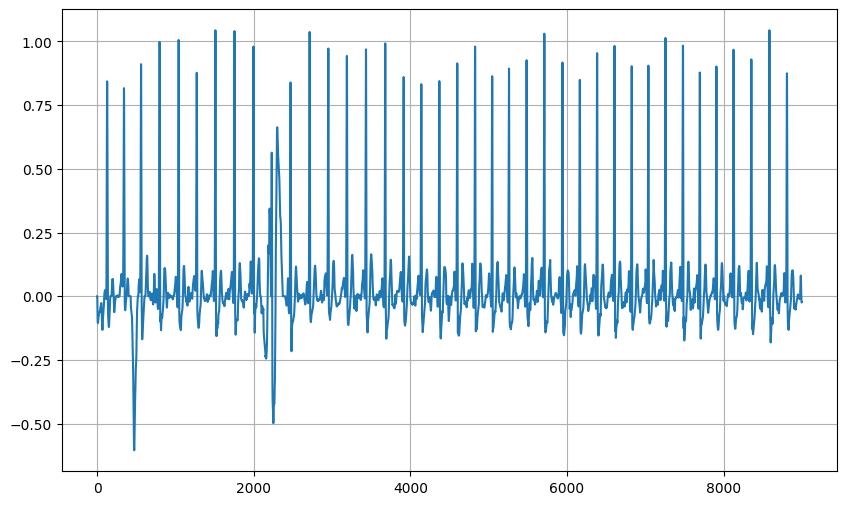

In [10]:
def load_and_preprocess_data(file_name, data_dir):
    # Load data
    data = load_data(file_name, data_dir)
    # Baseline wander removal
    data = baseline_wander_removal(data)
    # Normalize
    data = normalize_data(data)
    return data.astype(np.float32)

# Example
file_name = 'A00001'
data = load_and_preprocess_data(file_name, data_dir)

plt.figure()
plt.plot(data)
plt.show()

### 2.1 - Dataset definition
Now, let's define the `create_dataset` function following the same steps in Lab 3. 

#### - **Create a Dataset object**
We use the method `from_tensor_slices` to instantiate a `tf.data.Dataset` object, which iteratively gets data from given tensors ([documentation here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)). 
While in Lab 3 we implemented an unsupervised learning technique (autoencoder), in this Lab we want to implement a classifier (supervised learning) and, in turn, we need to include labels in our Dataset.
Specifically, we use as arguments a tuple composed of the `file_names` list (\['A00001', 'A00002', ...\]) and the `labels` list (\[0, 0, 1, 0, ...\]), both extracted from the `reference_df` dataframe (e.g., the previously evaluated *train_reference_df* or *val_reference_df*).

#### - **Map the load_and_preprocess_data function**
In this case, we want to transform the filename string (e.g., 'A00001') to a 32-bit tensor containing the actual preprocessed data using the `load_and_preprocess_data` function.
We use the `map()` method ([documentation here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)) combined with `tf.numpy_function` ([documentation here](https://www.tensorflow.org/api_docs/python/tf/numpy_function)) to include arbitrary Python functions inside the TensorFlow graph.

The `map()` function converts your dataset entries from (filename, label) to (preprocessed ECG data, label).

#### - **Cache the dataset**
In this example, both the baseline wander removal and the normalization steps can be performed a single time on the entire dataset, since the result is always the same. Thus, we use caching to store partial results both in a file or in memory (RAM) ([documentation here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache)).

**IMPORTANT NOTE**: Remember that the order of the dataset transformations is very important, especially when using a caching system. For example, if you applied the cache **after** the random crop operation, your samples would be cropped only the first time, and stored in the cache. All the subsequent calls would have always returned the same exact crop, resulting in both a waste of data and more overfitting issues.

#### - **Shuffle**
Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

#### - **Repeat the dataset indefinitely**
Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat).

#### - **Map the crop function**
Now we can map the random crop function. The previous important note for the cache also holds for the ``repeat()`` function. If you applied the random crop **before** the ``repeat()``, the same crop would have been repeated indefinitely. So always pay attention to the proper order!

#### - **Correct input shape for the network**
Since the required network input shape is (batch, time_axis, channels) in this case, we need to add the channel axis to the data. We simply expand the rank of the tensor from the shape (9000,) to (9000, 1). The data content is not affected.

#### - **Batch**
Put together *batch_size* samples into a single batch of data, which will be the input of the network. The shape of the data changes from (9000, 1) to (batch_size, 9000, 1).

#### - **Prefetch**
With this operation we go from this situation:

<img src="img/datasets_without_pipelining.png" width="600"/>

to:

<img src="img/datasets_with_pipelining.png" width="600"/>

You can find more details [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [11]:
def create_dataset(reference_df, input_size, center_crop, batch_size, shuffle, cache_file=None):
    # Convert dataframe to lists
    file_names = list(reference_df.index)
    labels = reference_df['label']

    # Create a Dataset object
    ### START CODE HERE ### (1 line) 
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    ### END CODE HERE ###  

    # Map the load_and_preprocess_data function
    ### START CODE HERE ### (2 lineS)
    py_func = lambda file_name, label: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    ### END CODE HERE ###

    # Cache dataset
    if cache_file:
        ### START CODE HERE ### (1 line) 
        dataset = dataset.cache(cache_file)
        ### END CODE HERE ### 

    # Shuffle
    if shuffle:
        ### START CODE HERE ### (1 line) 
        dataset = dataset.shuffle(len(file_names))
        ### END CODE HERE ###

    # Repeat the dataset indefinitely
    ### START CODE HERE ### (1 line) 
    dataset = dataset.repeat()
    ### END CODE HERE ###

    # Map the crop function
    py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, input_size, center_crop], tf.float32), input_size), label)
    dataset = dataset.map(py_func)

    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))

    # Batch
    ### START CODE HERE ### (1 line) 
    dataset = dataset.batch(batch_size=batch_size)
    ### END CODE HERE ###

    # Prefetch
    ### START CODE HERE ### (1 line) 
    dataset = dataset.prefetch(buffer_size=1)
    ### END CODE HERE ###

    return dataset

### 2.2 - Dataset initialization
Now we can finally define our training and validation datasets.

We also evaluate the number of steps (*train_steps* and *val_steps*) required to load and process the entire dataset (num. of samples / batch_size).

Remember that *center_crop* should be *False* for the training set and *True* for the validation, and shuffling should be enabled only for the training set.

In [12]:
input_size = 9000
batch_size = 32
train_dataset = create_dataset(
                            train_reference_df, 
                            input_size=input_size, 
                            center_crop=False, 
                            batch_size=batch_size, 
                            shuffle=True,
                            cache_file='train_cache')

val_dataset = create_dataset(
                            val_reference_df, 
                            input_size=input_size, 
                            center_crop=True, 
                            batch_size=batch_size, 
                            shuffle=False,
                            cache_file='val_cache')

train_steps = int(np.ceil(len(train_reference_df)/batch_size))
val_steps = int(np.ceil(len(val_reference_df)/batch_size))

2022-12-11 18:16:33.123454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 18:16:33.126263: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


For example, to show the effectiveness of the caching system, let's try to create a small dataset (just 96 samples). Then, let's measure the loading time of 3 epochs.

As you can see, the first epoch requires much longer to load and process data. While the other 2 prepare data almost instantly.

In [13]:
example_dataset = create_dataset(
                                reference_df[:96],
                                input_size=input_size,
                                center_crop=False,
                                batch_size=batch_size,
                                shuffle=False,
                                cache_file='cache_example')
iterat = iter(example_dataset)
# Iterate for 3 epochs
for num_epoch in range(3):
    # Time the loading time
    it = time.time()
    for step in tqdm(range(3)):
        # Get the next batch of data
        next(iterat)
    # Print loading time
    print('EPOCH {} - Time to load the entire dataset [seconds]: {}'.format(num_epoch+1, time.time() - it))

# Remove the created cache
os.remove('cache_example.data-00000-of-00001')
os.remove('cache_example.index')

100%|██████████| 3/3 [00:17<00:00,  5.72s/it]


EPOCH 1 - Time to load the entire dataset [seconds]: 17.1809504032135


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


EPOCH 2 - Time to load the entire dataset [seconds]: 0.18237829208374023


100%|██████████| 3/3 [00:00<00:00, 36.21it/s]

EPOCH 3 - Time to load the entire dataset [seconds]: 0.08814549446105957


 To save some time (the full creation of the caches may require about 30 minutes depending on your hardware), the caches of the train and validation sets are provided. Keep in mind that this is not a good practice and may cause some issues. Typically cache files should not be transferred among different machines.

 If you have problems with the provided cache files, just delete/rename them (all the files starting with *train_cache* and *val_cache*) and recreate your own caches.

 ## 3 - Model definition
 Here, you are free to define your network architecture.

 As a starting point, we propose the following network, where the first three layers are monodimensional convolutions (the input is a signal), and then we have a gated recurrent unit (GRU) before the fully connected layer:
 - Input of shape (None, 9000, 1)
 - Layer 1
   - Conv1D with 32 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLU
 - Layer 2
   - Conv1D with 64 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLU
 - Layer 3
   - Conv1D with 128 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLU
 - Layer 4
   - GRU with 128 units
 - Layer 5
   - Dense with 1 output (probability of the input sample to be an Afib)

Layers' documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers#classes_2).
Below, you find the structure to build the network model using the `Model` class but feel free to use the `Sequential` one instead.

**NOTE**: Even though theoretically a recurrent network is capable of storing indefinite long-term relationships, practical backpropagation limits and numerical issues restrict their actual memory. Feeding a GRU directly with 9000 samples (i.e., without using the Conv layers) is quite inefficient and unlikely the network will converge to a good minimum. The purposes of the convolutional layers are:

1) to reduce the dimensionality of the input (using the strides)
2) to extract higher-level information before the GRU layer

**Hint**: Since we do not have real-time requirements, you can also consider using a bidirectional GRU.

In [14]:
def MyModel(input_shape):
    """
    Arguments:
    input_shape -- shape of the data of the dataset

    Returns:
    model -- a tf.keras.Model() instance
    """
    
    X_input = tf.keras.Input(input_shape)

    # CONV -> Batch Normalization -> ReLU Block applied to X
    
    ### START CODE HERE ### (9 lines) 
    X = tf.keras.layers.Conv1D(32, 9, strides=4, name='conv0')(X_input)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(64, 9, strides=4, name='conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(128, 9, strides=4, name='conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    ### END CODE HERE ### 
    
    # GRU 
    ### START CODE HERE ### (1 line) 
    X = tf.keras.layers.GRU(128, name='gru0')(X)
    ### END CODE HERE ### 

    # FLATTEN X + FULLYCONNECTED
    ### START CODE HERE ### (2 lines) 
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(1, activation='sigmoid', name='fc')(X)
    ### END CODE HERE ### 

    # Create the Keras model. This creates your Keras model instance, you'll use this instance to train/test the model.
    ### START CODE HERE ### (1 line) 
    model = tf.keras.Model(inputs=X_input, outputs=X, name='MyModel')
    ### END CODE HERE ### 
    
    return model

In [15]:
input_shape = (input_size, 1)

# Call the function to create the model and compile it (Hint. Parameters: optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
### START CODE HERE ### (2 lines) 
model = MyModel(input_shape)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
### END CODE HERE ### 

 ## 4 - Model training and testing
 ### 4.1 - Model training
 Now let's train the model for some epochs. Then plot the loss values and the accuracy during training.
 To fit the model use the parameters:
 ```python
model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=train_steps, validation_data=val_dataset, validation_steps=val_steps, callbacks=[early_stop_callback])
```
Here we use the early stopping [callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [16]:
# Train the model
num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
### START CODE HERE ### (1 line)
history = model.fit(train_dataset,
                    epochs=num_epochs, 
                    steps_per_epoch=train_steps, 
                    validation_data=val_dataset, 
                    validation_steps=val_steps,
                    callbacks=[early_stop_callback])
### END CODE HERE ### 

# Save the model
### START CODE HERE ### (1 line)
model.save('my_model.h5')
### END CODE HERE ### 

Epoch 1/30


2022-12-11 18:17:08.453068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 54 of 4667
2022-12-11 18:17:19.092888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 110 of 4667
2022-12-11 18:17:28.589591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 168 of 4667
2022-12-11 18:17:38.604115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 4667
2022-12-11 18:17:48.856408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 294 of 4667
2022-12-11 18:17:58.698515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 360 of 4667
2022-12-11 18:18:08.565565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle bu

146/146 [==============================] - 752s 1s/step - loss: 0.3882 - accuracy: 0.8669 - val_loss: 0.3861 - val_accuracy: 0.8699
Epoch 2/30


2022-12-11 18:29:24.896192: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


146/146 [==============================] - 43s 293ms/step - loss: 0.3003 - accuracy: 0.8906 - val_loss: 0.4862 - val_accuracy: 0.8699
Epoch 3/30
146/146 [==============================] - 42s 287ms/step - loss: 0.2159 - accuracy: 0.9210 - val_loss: 0.5063 - val_accuracy: 0.8708
Epoch 4/30
146/146 [==============================] - 42s 286ms/step - loss: 0.1385 - accuracy: 0.9482 - val_loss: 0.1231 - val_accuracy: 0.9510
Epoch 5/30
146/146 [==============================] - 41s 283ms/step - loss: 0.0886 - accuracy: 0.9717 - val_loss: 0.0937 - val_accuracy: 0.9654
Epoch 6/30
146/146 [==============================] - 43s 291ms/step - loss: 0.0694 - accuracy: 0.9752 - val_loss: 0.0926 - val_accuracy: 0.9671
Epoch 7/30
146/146 [==============================] - 42s 289ms/step - loss: 0.0579 - accuracy: 0.9803 - val_loss: 0.0810 - val_accuracy: 0.9721
Epoch 8/30
146/146 [==============================] - 41s 277ms/step - loss: 0.0370 - accuracy: 0.9863 - val_loss: 0.1097 - val_accuracy: 0.9

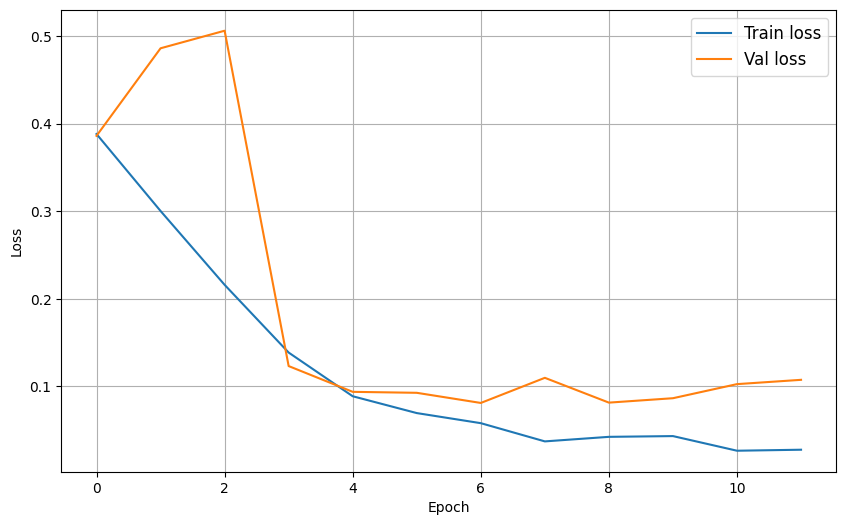

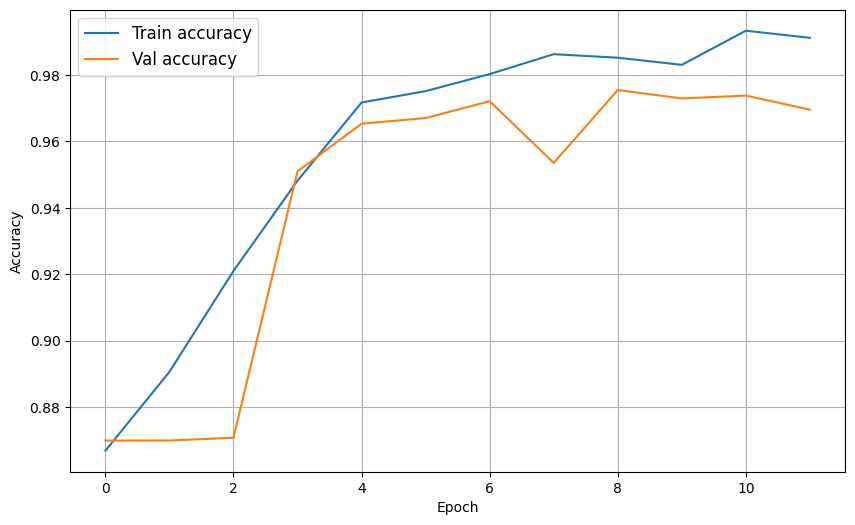

In [17]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

If you do not want to wait for the training to finish, you can load some pre-trained models.

Just uncomment the line of code below.

In [18]:
model = tf.keras.models.load_model('model.h5')

model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv0 (Conv1D)              (None, 2248, 32)          320       
                                                                 
 bn0 (BatchNormalization)    (None, 2248, 32)          128       
                                                                 
 activation_3 (Activation)   (None, 2248, 32)          0         
                                                                 
 conv1 (Conv1D)              (None, 560, 64)           18496     
                                                                 
 bn1 (BatchNormalization)    (None, 560, 64)           256       
                                                                 
 activation_4 (Activation)   (None, 560, 64)           0   

## 5 - Some validation metrics
The accuracy is not a good metric when the dataset is unbalanced, as in this case. Additional metrics are required to have a good understanding of the classifier performance, as seen in Lab 4.

Let's evaluate the **precision**, **recall** and **fscore** metrics using some methods from the *scikit-learn* library ([documentation here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

Recap from Lab 4: first, we need the output of the network for all the validation samples. To obtain it use:
```python 
model.predict(val_dataset, steps=val_steps)[:len(val_labels)].squeeze()
```
The ```[:len(val_labels)]``` is needed because the elements in ```[len(val_labels):]``` are not part of our dataset, they are added to complete the batch (in fact ```len(val_labels)=1167``` while to complete the final batch the elements are a total of 1184).

Then, if the output is < 0.5, the estimated class is normal sinus rhythm, otherwise an Afib has been detected: use
```python 
(val_preds > 0.5).astype(int)
```

In [19]:
# Get the validation labels
val_labels = val_reference_df['label'].values

# Get the network output for the validation set
### START CODE HERE ### (1 line)
val_preds = model.predict(val_dataset, steps=val_steps)[:len(val_labels)].squeeze()
### END CODE HERE ### 

# Get the estimated classes
### START CODE HERE ### (1 line)
val_est_classes = (val_preds > 0.5).astype(int)
### END CODE HERE ### 

# Evaluate accuracy
### START CODE HERE ### (1 line)
accuracy = accuracy_score(val_labels, val_est_classes)
### END CODE HERE ### 

# Evaluate precision, recall and fscore
### START CODE HERE ### (1 line)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_est_classes, average='binary')
### END CODE HERE ### 

print('#### VALIDATION PERFORMANCE')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Afib that are actually Afib): {:.2f}%'.format(precision*100))
print('Recall (fraction of Afib correctly classified as Afib): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

37/37 [==============================] - 3s 67ms/step
#### VALIDATION PERFORMANCE
Accuracy: 96.92%
Precision (fraction of ECG classified as Afib that are actually Afib): 84.94%
Recall (fraction of Afib correctly classified as Afib): 92.76%
Fscore (harmonic mean of precision and recall): 88.68%


 As you can see, even though the accuracy is around 97% (using the pre-trained model), the precision and recall are considerably smaller (not too bad anyway).

**NOTE** You should be careful when dealing with an unbalanced dataset. For example, since in this case about 87% of the samples are of class 0, a dummy classifier whose output is always 0 would get an 87% accuracy, which may appear as a good result at first, while it's actually the worst you can get.
In the same case, precision and recall would easily point out the bad performances.

### 5.1 - Receiver operating characteristic (ROC) curve
Plot the ROC as seen in Lab 4. The curve is obtained by evaluating the *False Positive Rate* and the *True Positive Rate* by varying the threshold used to infer the estimated classes (0.5 in the previous case).

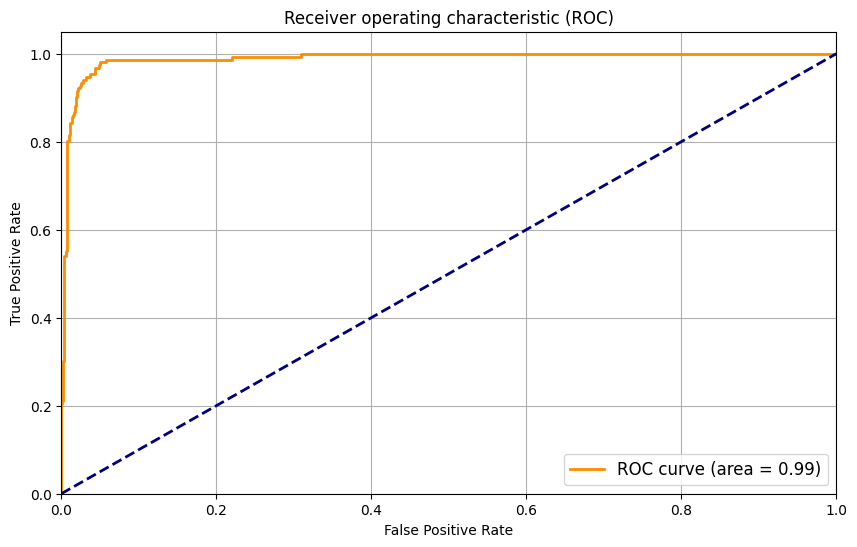

In [20]:
### START CODE HERE ### (2 line)
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)
### END CODE HERE ###

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 5.2 - Precision-Recall Curve (PRC)
Plot the PRC.

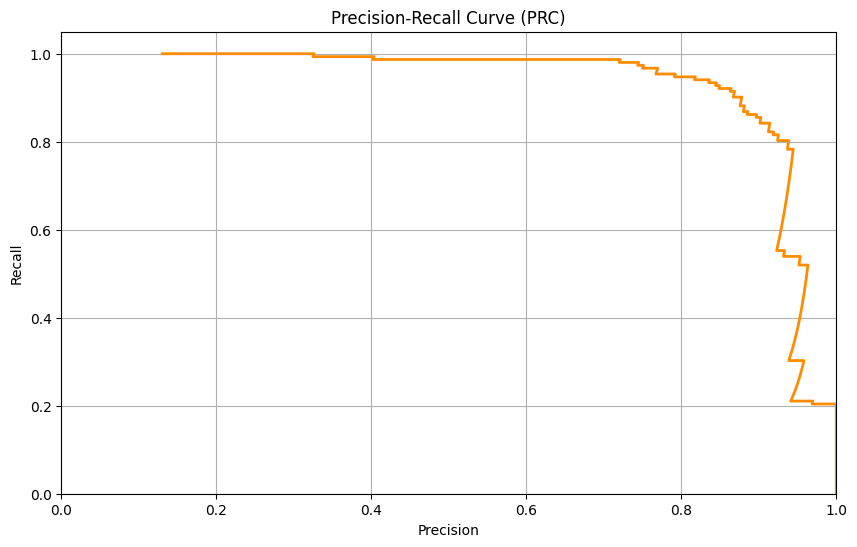

In [21]:
### START CODE HERE ### (2 line)
prec, rec, _ = precision_recall_curve(val_labels, val_preds)
### END CODE HERE ###

plt.figure()
plt.plot(prec, rec, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve (PRC)')
plt.show()

Congratulations! Lab 5 successfully completed :)